tgb - 5/28/2019 - The goal of this notebook is to develop MSE-ranked diagnostics in the hope to identify climate conditions in which our network performs poorly. What we have so far is the average error for each variable in the md.stats object. The goal is to do the opposite: The climate variable as a function of the error.

# 1) Loading CBRAIN

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.model_diagnostics import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

# 2) Calculate mean of variables conditioned on MSE

## 2.1) Define models

tgb - 5/28/2019 - For now use the best performing LCnet and LACnet

In [4]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/NNA0.01.h5'
NN['NNA0.01'] = load_model(path,custom_objects=dict_lay)
md['NNA0.01'] = ModelDiagnostics(NN,config_fn,data_fn)
# NNL0.01
path = TRAINDIR+'HDF5_DATA/NNL0.01.h5'
NN['NNL0.01'] = load_model(path,custom_objects=dict_lay)
md['NNL0.01'] = ModelDiagnostics(NN,config_fn,data_fn)

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
NNa = ['NNA0.01','NNL0.01'] # LACnet and LCnet

## 2.2) Accumulates all variables over Nt timesteps, with a focus on P-CWV

In [6]:
# User's choice
Nt = 100

P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# Initialization
CWVtot = np.zeros((len(coor.lat),len(coor.lon),1))
QVtot = np.zeros((len(coor.lat),len(coor.lon),len(coor.lev),1))
Ttot = np.copy(QVtot)
CSHtot = np.copy(CWVtot)
xtot = np.zeros((len(coor.lat),len(coor.lon),304,1))
PRECtot = np.zeros((len(coor.lat),len(coor.lon),1))

PREC_NN = {}; MSE_NN = {};
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = np.zeros((len(coor.lat),len(coor.lon),1))
    MSE_NN[NNname] = np.copy(PREC_NN[NNname])

for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md[NNname] # Reference model diagnostic object
    # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
    X, truth = m.valid_gen[itime]
    PRECIP = (np.sum(truth.values[:,-4:-2],axis=1))*P_CONV/(L_V*RHO_L)
    # 2) Save mean input
    xgeo = m.reshape_ngeo(m.valid_gen.input_transform.inverse_transform(X).values)
    xtot = np.concatenate((xtot,np.expand_dims(xgeo[:,:,:],axis=3)),axis=3)
    # 3) Water vapor
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)
    QVtot = np.concatenate((QVtot,np.expand_dims(QVgeo[:,:,:],axis=3)),axis=3)
    CWVgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*QV/G,axis=1),axis=1))
    CWVtot = np.concatenate((CWVtot,CWVgeo[:,:,:][:,:,:]),axis=2)
    # 4) Precipitation
    PRECgeo = m.reshape_ngeo(PRECIP)
    PRECtot = np.concatenate((PRECtot,PRECgeo[:,:,:][:,:,:]),axis=2)
    # 5) Temperature
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    Tgeo = m.reshape_ngeo(T.values)[:,:,:]
    Ttot = np.concatenate((Ttot,np.expand_dims(Tgeo[:,:,:],axis=3)),axis=3)
    CSHgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*C_P*T/(L_V*G),axis=1),axis=1))
    CSHtot = np.concatenate((CSHtot,CSHgeo[:,:,:][:,:,:]),axis=2)
    # 5) Precipitation from NN prediction
    for iNN,NNname in enumerate(NNa):
        pred = md[NNname].model[NNname].predict_on_batch(X)
        PRECIP_NN = (np.sum(pred[:,-4:-2],axis=1))*P_CONV/(L_V*RHO_L)
        PREC_NN[NNname] = np.concatenate((
            PREC_NN[NNname],
            md[NNname].reshape_ngeo(PRECIP_NN)[:,:,:][:,:,:]),
            axis=2)
        MEANSE_NN = np.sum((pred-truth.values)**2,axis=1)/pred.shape[1]
        MSE_NN[NNname] = np.concatenate((
            MSE_NN[NNname],
            md[NNname].reshape_ngeo(MEANSE_NN)[:,:,:][:,:,:]),
            axis=2)

# Remove initial zero
QVtot = QVtot[:,:,:,1:]
Ttot = Ttot[:,:,:,1:]
CWVtot = CWVtot[:,:,1:]
CSHtot = CSHtot[:,:,1:]
PRECtot = PRECtot[:,:,1:]
xtot = xtot[:,:,:,1:]
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]
    MSE_NN[NNname] = MSE_NN[NNname][:,:,1:]

In [7]:
# First use column water vapor as binning variable to test
# Histogram parameters
Nbin = 100
CWVmin = 20
CWVmax = 70
# Initialization
CWVm = np.zeros((Nbin-1,1))
CSHm = np.copy(CWVm)
Pm = np.copy(CWVm)

PNNm = {}; MSENNm = {};
for iNN,NNname in enumerate(NNa):
    PNNm[NNname] = np.copy(Pm)
    MSENNm[NNname] = np.copy(Pm)

for ibin,edge in enumerate(np.linspace(CWVmin,CWVmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        Pm[ibin-1] = np.average(PRECtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        CSHm[ibin-1] = np.average(CSHtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        for iNN,NNname in enumerate(NNa):
            PNNm[NNname][ibin-1] = np.average(
                PREC_NN[NNname],
                weights=(CWVtot>=edge_left)*(CWVtot<edge))
            MSENNm[NNname][ibin-1] = np.average(
                MSE_NN[NNname],
                weights=(CWVtot>=edge_left)*(CWVtot<edge))
        
    edge_left = edge

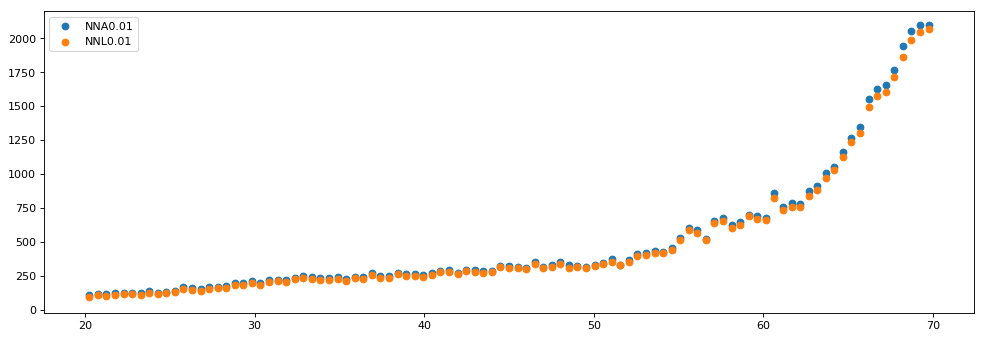

In [8]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
for iNN,NNname in enumerate(NNa):
    plt.scatter(CWVm,MSENNm[NNname],label=NNname)
plt.legend()

tgb - Then flip it and use the MSE as the binning variable

In [9]:
# Model choice
MSEtot = MSE_NN['NNA0.01']
# Histogram parameters
Nbin = 100
MSEmin = 0
MSEmax = 2e3
# Initialization
CWVm = np.zeros((Nbin-1,1))
CSHm = np.copy(CWVm)
Pm = np.copy(CWVm)
MSEm = np.copy(CWVm)
lattot = np.expand_dims(np.expand_dims(lat.values,axis=1),axis=2)
for i in range(2):
    lattot = np.repeat(lattot,CWVtot.shape[i+1],axis=i+1)
latm = np.copy(CWVm)

for ibin,edge in enumerate(np.linspace(MSEmin,MSEmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        Pm[ibin-1] = np.average(PRECtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        CSHm[ibin-1] = np.average(CSHtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        MSEm[ibin-1] = np.average(MSEtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        latm[ibin-1] = np.average(lattot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        
    edge_left = edge

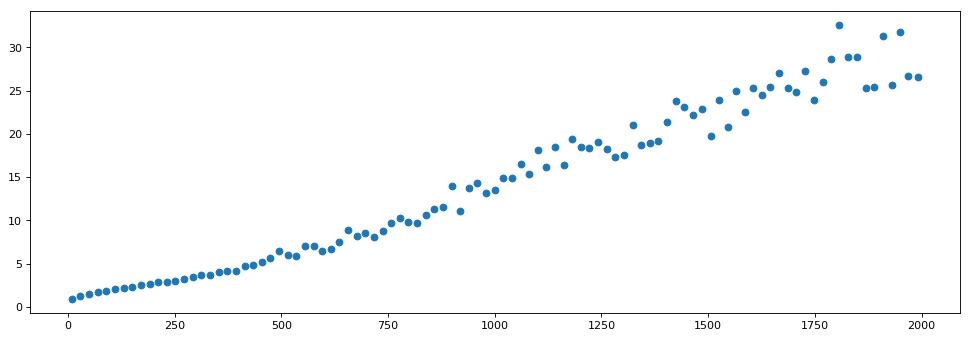

In [10]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,Pm)

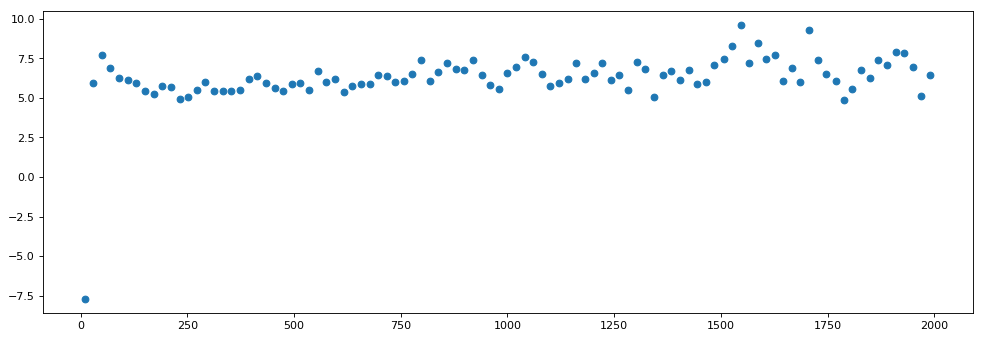

In [12]:
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,latm)

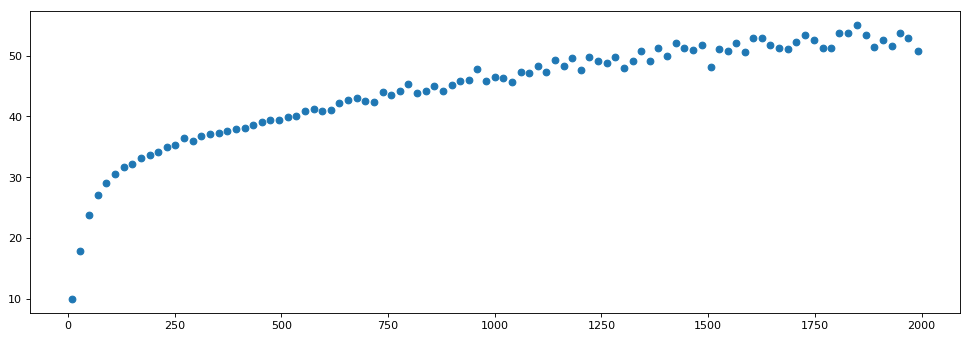

In [11]:
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,CWVm)

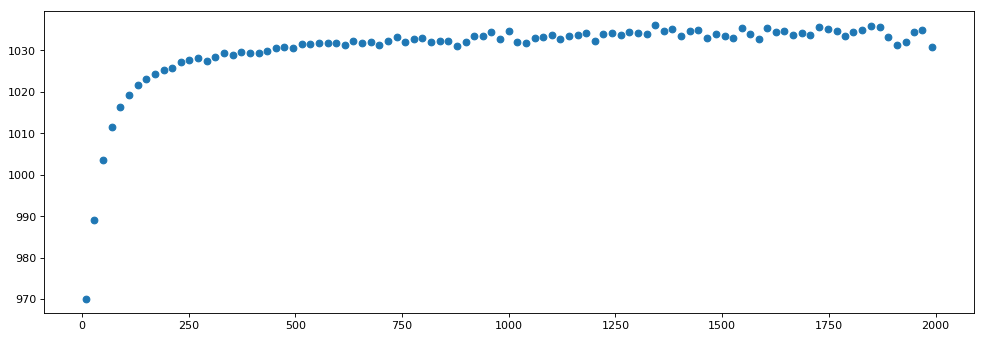

In [13]:
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,CSHm)

In [81]:
lattot = np.expand_dims(np.expand_dims(lat.values,axis=1),axis=2)

In [82]:
lattot.shape

(64, 1, 1)

In [84]:
lattot = np.repeat(lattot,CWVtot.shape[1],axis=1)

In [89]:
lattot.shape

(4096, 1, 100)